Dataset https://www.kaggle.com/datasets/sshikamaru/car-object-detection/code

Part of code from https://tarunbisht.com/deep%20learning/2024/03/24/pytorch-rcnn-tutorial-object-detection/

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
import matplotlib.pyplot as plt
import glob
import cv2
import dask.dataframe as dd
import os
import selectivesearch
import torchvision
import numpy as np
from ultralytics import YOLO

In [2]:
class CarDataset(Dataset):
    
    def __init__(self, path, y_path, transform=None):
        self.path = path
        self.imgs_path = glob.glob(os.path.join(path, "*"))
        self.y_path = y_path
        self.y_ds = dd.read_csv(y_path, encoding="UTF-8").compute()
        self.transform = transform
    
    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self, index):
        image_path = self.imgs_path[index]
        image_name = os.path.basename(image_path)
        x = cv2.imread(image_path)
        image_ds = self.y_ds[self.y_ds["image"] == image_name]

        # Assuming the label is a single column named 'label'
        y = image_ds[['xmin','ymin','xmax','ymax']].values
        y = torch.tensor(y, dtype=torch.float32)
        
        if self.transform:
            x = self.transform(x)

        return x, y


In [3]:
train_path = "data/training_images"
train_boxes_path = "data/train_solution_bounding_boxes (1).csv"
testing_path = "data/training_images"

In [4]:
train_ds = CarDataset(train_path, train_boxes_path)

In [6]:
train_ds.y_ds.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


## Building Selective Search

In [7]:
image = cv2.imread("data/training_images/vid_4_720.jpg")

In [8]:
new_height = 380
print(image.shape)
# Retrieve the width of the image
image.shape[1]
# Calculate the scaling factor for the image's height
(new_height / (image.shape[0]))

(380, 676, 3)


1.0

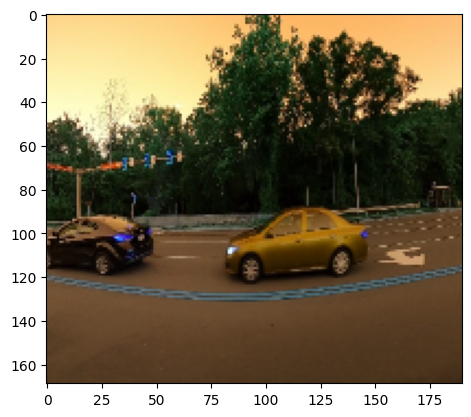

In [9]:
# Calculate a new height
new_height = int(image.shape[1] / 4)
# Calculate a new width
new_width = int(image.shape[0] / 2)
# Resize the image to the new dimensions
resized_image = cv2.resize(image, (new_width, new_height))

# Display the resized image using Matplotlib
plt.imshow(resized_image)
plt.show()


In [10]:
# applying selective search
img_lbl, regions = selectivesearch.selective_search(
	resized_image, scale=500, sigma=0.9, min_size=10)


e:\Misha\programming\learning\car_detection\venv\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [13]:
# Initialize an empty set to store selected region proposals
candidates = set()

# Iterate over all the regions detected by Selective Search
for r in regions:
	# Check if the current region's rectangle is already in candidates
	if r['rect'] in candidates:
		continue # Skip this region if it's a duplicate

	# Check if the size of the region is less than 200 pixels
	# if r['size'] < 200:
	# 	continue # Skip this region if it's too small

	# Extract the coordinates and dimensions of the region's rectangle
	x, y, w, h = r['rect']

	# Avoid division by zero by checking if height or width is zero
	if h == 0 or w == 0:
		continue # Skip this region if it has zero height or width

	# Check the aspect ratio of the region (width / height and height / width)
	# if w / h > 1.2 or h / w > 1.2:
	# 	continue # Skip this region if its aspect ratio is not within a range

	# If all conditions are met, add the region's rectangle to candidates
	candidates.add(r['rect'])


In [14]:
len(candidates)

61

In [15]:
# Convert the selected bounding boxes to the original image size
def selective_search(image):
	candidates_scaled = [(int(x * (image.shape[1] / new_width)),
						int(y * (image.shape[0] / new_height)),
						int(w * (image.shape[1] / new_width)),
						int(h * (image.shape[0] / new_height)))
						for x, y, w, h in candidates]

	return candidates_scaled


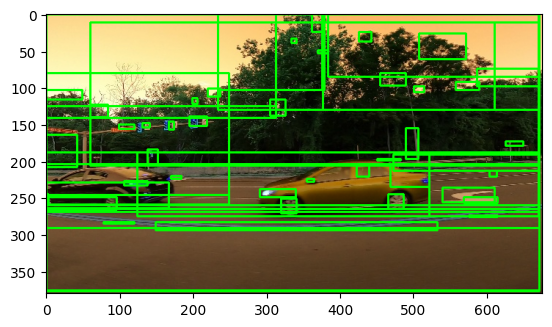

In [16]:
# Load the image
image_path = 'data/training_images/vid_4_720.jpg'
image = cv2.imread(image_path)

# Get selective search object proposals
proposals = selective_search(image)

# Draw the proposals on the image
output_image = image.copy()
for (x, y, w, h) in proposals:
	cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the result 
plt.imshow(output_image)
plt.show()


In [17]:
label_2_idx = {'car': 20, 'bg': 0}
idx_2_label = {20: 'car', 0: 'bg'}

In [18]:
def draw_boxes(img, boxes, scores, labels, class_map=None):
    nums = len(boxes)
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2])).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4])).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        label = int(labels[i])
        if class_map is not None:
            label_txt = class_map[label]
        else:
            label_txt = str(label)
        img = cv2.putText(
            img,
            "{} {:.4f}".format(label_txt, scores[i]),
            x1y1,
            cv2.FONT_HERSHEY_COMPLEX_SMALL,
            1,
            (0, 0, 255),
            2,
        )
    return img

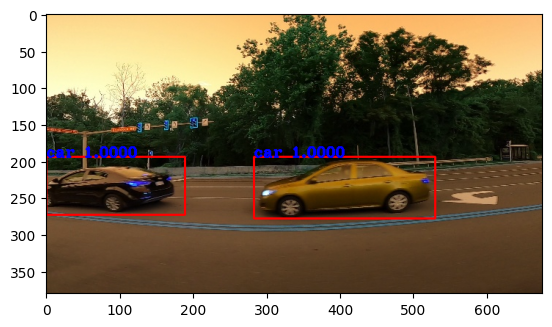

In [19]:
sample_image, boxes = train_ds[887]
sample_image = np.array(sample_image)
labels = [label_2_idx["car"] for x in boxes]
scores = [1]*len(labels)
final_image = draw_boxes(sample_image, boxes, scores, labels, idx_2_label)
plt.imshow(final_image)
plt.show()

### Another method

In [116]:
normalized_transform = torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])
def process_inputs(image, max_selections=300, section_size=(224, 224)):
    images = []
    boxes = []
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchQuality()
    rects = ss.process()[:max_selections]
    rects = np.array([[x, y, x+w, y+h] for x, y, w, h in rects])
    for rect in rects:
        x1, y1, x2, y2 = rect
        img_section = image[y1: y2, x1: x2]
        img_section = cv2.resize(img_section, section_size)
        images.append(img_section)
        boxes.append(rect)
    images = np.array(images, dtype=np.int32)
    return images, np.array(boxes)

In [127]:
proposals = process_inputs(cv2.imread(image_path))

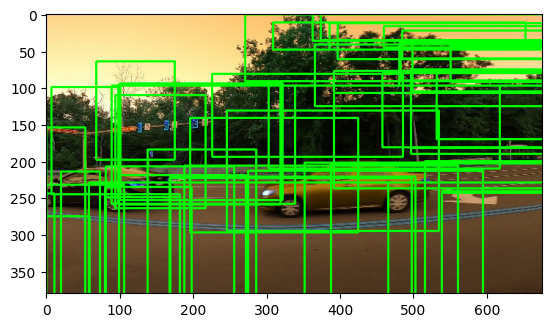

In [128]:
output_image = image.copy()
for (x, y, w, h) in proposals[1][:50]:
	cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the result 
plt.imshow(output_image)
plt.show()


In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Get YOLO classifier

In [28]:


# Load a pre-trained YOLOv8 model
model = YOLO('yolov8n-cls.pt')

# Load an image
img_path = 'data/training_images/vid_4_720.jpg' 
img = cv2.imread(img_path)
car_class_num = 817

# Perform inference
results = model(img)

# Print results
print(results[0].probs.data[car_class_num])  # Print results to console



0: 224x224 sports_car 0.54, convertible 0.15, racer 0.09, limousine 0.08, minivan 0.03, 142.9ms
Speed: 65.6ms preprocess, 142.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
tensor(0.5411)



0: 224x224 sports_car 0.53, convertible 0.11, amphibian 0.11, racer 0.09, car_wheel 0.07, 46.5ms
Speed: 20.5ms preprocess, 46.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
0.5332543253898621


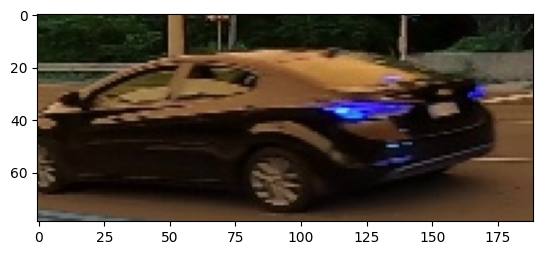

In [36]:
sample_image, boxes = train_ds[887]
x1,y1,x2,y2 = [int(coord) for coord in boxes[0]]
car_image = sample_image[y1:y2, x1:x2, :]
results = model(car_image)
print(float(results[0].probs.data[car_class_num]))
plt.imshow(car_image)
plt.show()

We are using class "sport car" for our task

In [140]:
import logging 

logging.getLogger("ultralytics").setLevel(logging.WARNING)
model = YOLO('yolov8n-cls.pt')
def get_car_score(image):

    if image.dtype == np.int32:
        image = image.astype(np.uint8)

    results = model(image)
    car_class_num = 817
    
    # Extract and return the probability of the car class
    car_probability = results[0].probs.data[car_class_num].item()
    
    return car_probability

In [129]:
image = cv2.imread(image_path)
prop_imgs, prop_boxes = proposals

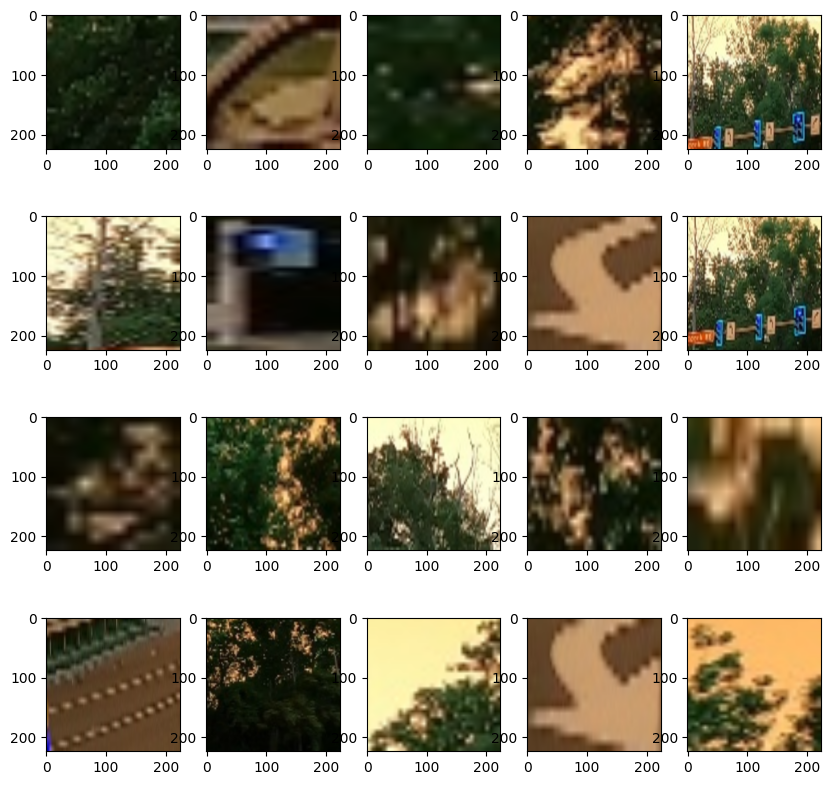

In [130]:
fig = plt.figure(figsize=(10, 10))
columns = 5
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(prop_imgs[i])
plt.show()

IoU score and Non max supression

In [166]:
def calculate_iou_score(box_1, box_2):
    '''
        box_1 = single of ground truth bounding boxes
        box_2 = single of predicted bounded boxes
    '''
    box_1_x1 = box_1[0]
    box_1_y1 = box_1[1]
    box_1_w = box_1[2]
    box_1_h = box_1[3]
    box_1_x2 = box_1_x1 + box_1_w
    box_1_y2 = box_1_y1 + box_1_h

    box_2_x1 = box_2[0]
    box_2_y1 = box_2[1]
    box_2_w = box_2[2]
    box_2_h = box_2[3]
    box_2_x2 = box_2_x1 + box_2_w
    box_2_y2 = box_2_y1 + box_2_h

    x1 = np.maximum(box_1_x1, box_2_x1)
    y1 = np.maximum(box_1_y1, box_2_y1)
    x2 = np.minimum(box_1_x2, box_2_x2)
    y2 = np.minimum(box_1_y2, box_2_y2)

    area_of_intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    area_box_1 = (box_1_x2 - box_1_x1 + 1) * (box_1_y2 - box_1_y1 + 1)
    area_box_2 = (box_2_x2 - box_2_x1 + 1) * (box_2_y2 - box_2_y1 + 1)
    area_of_union = area_box_1 + area_box_2 - area_of_intersection

    return area_of_intersection/float(area_of_union)

In [163]:
def non_max_supression(boxes, scores, threshold=0.5, iou_threshold=0.5):
    idxs = np.where(scores>threshold)
    boxes = boxes[idxs]
    scores = scores[idxs]
    idxs = np.argsort(scores)
    chossen_boxes = []
    choosen_boxes_scores = []
    while len(idxs):
        last = len(idxs) - 1
        choosen_idx = idxs[last]
        choosen_box = boxes[choosen_idx]
        choosen_box_score = scores[choosen_idx]
        chossen_boxes.append(choosen_box)
        choosen_boxes_scores.append(choosen_box_score)
        idxs = np.delete(idxs, last)
        i = len(idxs)-1
        while i >= 0:
            idx = idxs[i]
            curr_box = boxes[idx]
            curr_box_score = scores[idx]
            if (calculate_iou_score(curr_box, choosen_box) > iou_threshold):
                idxs = np.delete(idxs, i)
            i -= 1
    return chossen_boxes, choosen_boxes_scores

In [164]:
def process_outputs(scores, boxes, threshold=0.5, iou_threshold=0.5):
    assert len(scores) == len(boxes)
    final_boxes, final_boxes_scores = non_max_supression(boxes, scores, threshold, iou_threshold)
    return final_boxes, final_boxes_scores

In [225]:
image = cv2.imread(image_path)

In [173]:
prop_imgs, prop_boxes = process_inputs(image, max_selections=-1)
scores = np.array([get_car_score(image=prop_img) for prop_img in prop_imgs])

In [223]:
boxes, boxes_scores = process_outputs(scores=scores, boxes=prop_boxes, threshold=0.4, iou_threshold=0.1)

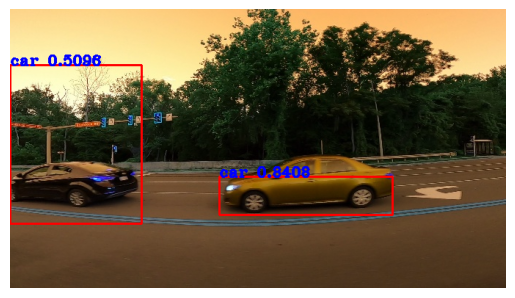

In [226]:
labels = [label_2_idx["car"] for x in boxes]
final_image = draw_boxes(
    image,
    boxes,
    boxes_scores,
    labels,
    idx_2_label
)
plt.axis("off")
plt.imshow(final_image)
plt.show()